In [1]:
import sys
import os
# Add the project root directory to the Python path
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(project_root)


## TinyQwenVl

In [2]:
SIGLIP_MODEL = "google/siglip-so400m-patch14-224"
QWEN_MODEL = "Qwen/Qwen2.5-0.5B"

from transformers import set_seed
set_seed(42)

### vision utils

In [3]:
from src.utils.vision_utils import add_image_padding
from src.preprocess import collate_fn
from transformers import AutoProcessor
processor = AutoProcessor.from_pretrained(SIGLIP_MODEL)

d:\miniconda3\envs\tinyqwenvl\Lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: '[WinError 127] The specified procedure could not be found'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
d:\miniconda3\envs\tinyqwenvl\Lib\site-packages\torchvision\datapoints\__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence t

keys,  dict_keys(['input_ids', 'pixel_values'])
torch.Size([1, 3, 224, 224])


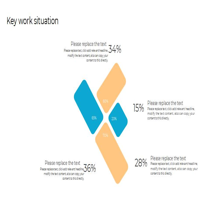

In [30]:
from PIL import Image as PILImage

# show image after padding
image = PILImage.open('../data/images/untitled.jpg')
image = add_image_padding(image, keep_ratio=False)

inputs = processor(
    text="An image of a cat",
    images=[image],
    padding="max_length",
    return_tensors="pt")

print('keys, ', inputs.keys())

print(inputs['pixel_values'].shape)
image.resize((224, 224))

In [ ]:
from transformers import AutoModel
import torch
# device cpu or gpu
device = "cuda" if torch.cuda.is_available() else "cpu"

vision_encoder = AutoModel.from_pretrained(
            SIGLIP_MODEL,
            torch_dtype=torch.float32,
            output_hidden_states=True
        ).to(device=device)
vision_encoder.eval()

In [40]:
image_features = vision_encoder.vision_model(inputs['pixel_values'].to(device))
image_features.last_hidden_state

tensor([[[-0.8282,  2.6053, -0.4908,  ..., -1.3949, -0.2332, -0.0353],
         [ 0.1090, -0.8591, -0.5404,  ..., -0.0412,  0.4451, -0.8356],
         [-0.4899,  0.4022, -2.3242,  ..., -1.0065,  0.5457, -1.8623],
         ...,
         [ 0.5033, -0.3226, -0.2965,  ...,  0.2671, -0.2212, -0.3060],
         [-2.0391,  1.8164, -0.2019,  ..., -1.9610, -2.2952, -1.3524],
         [-0.3558,  1.5829, -0.5931,  ...,  0.4165, -0.9983, -0.4905]]],
       device='cuda:0', grad_fn=<NativeLayerNormBackward0>)

In [36]:
outputs.vision_model_output.last_hidden_state

tensor([[[-0.8282,  2.6053, -0.4908,  ..., -1.3949, -0.2332, -0.0353],
         [ 0.1090, -0.8591, -0.5404,  ..., -0.0412,  0.4451, -0.8356],
         [-0.4899,  0.4022, -2.3242,  ..., -1.0065,  0.5457, -1.8623],
         ...,
         [ 0.5033, -0.3226, -0.2965,  ...,  0.2671, -0.2212, -0.3060],
         [-2.0391,  1.8164, -0.2019,  ..., -1.9610, -2.2952, -1.3524],
         [-0.3558,  1.5829, -0.5931,  ...,  0.4165, -0.9983, -0.4905]]],
       device='cuda:0', grad_fn=<NativeLayerNormBackward0>)

## Dataset: `lmms-lab/COCO-Caption`

In [ ]:
from datasets import load_dataset

dataset = load_dataset("lmms-lab/COCO-Caption", split="val")
drop_cols = ['question_id',
             'id',
             'license',
             'file_name',
             'coco_url',
             'height',
             'width',
             'date_captured']
dataset = dataset.remove_columns(drop_cols)
dataset

## Training phase

### load processor & tokenizer

In [23]:
from transformers import AutoProcessor, AutoTokenizer

processor = AutoProcessor.from_pretrained(SIGLIP_MODEL)
tokenizer = AutoTokenizer.from_pretrained(QWEN_MODEL, trust_remote_code=True)
# add special tokens extended
tokenizer.add_special_tokens({
    'pad_token': '<|endoftext|>',
    # Notes: Adding unknown special tokens is not supported
    # <|extra_0|> as begin image token
    # <|extra_1|> as end image token
    'additional_special_tokens': ['<|extra_0|>', '<|extra_1|>']
})

tokenizer.padding_side='right'

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


keys,  dict_keys(['input_ids', 'pixel_values'])
torch.Size([1, 3, 224, 224])


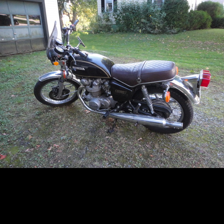

In [24]:
# show image after padding
image = add_image_padding(dataset[1]['image'])

inputs = processor(
    text=["dummy text here"], # no used
    images=[image],
    padding="max_length",
    return_tensors="pt")

print('keys, ', inputs.keys())

print(inputs['pixel_values'].shape)
image.resize((224, 224))

### process data & train/test split

In [25]:
split_dataset = dataset.train_test_split(test_size=0.2, seed=42)

In [26]:
import torch
from torch.utils.data import DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
batch_size = 16
val_loader = DataLoader(split_dataset["test"], batch_size=batch_size, shuffle=False,\
                        collate_fn=lambda batch: collate_fn(batch,
                                                            processor,
                                                            tokenizer))
# free memory by del dataset, split_dataset
del dataset
# del split_dataset

Using device: cuda


### show 1 sample was used for training


In [28]:
sample = next(iter(val_loader))
for key in sample.keys():
    print(f'{key}\t:\t{sample[key].shape}')

dummy_input_ids	:	torch.Size([16, 16])
pixel_values	:	torch.Size([16, 3, 224, 224])
input_ids	:	torch.Size([16, 291])
attention_mask	:	torch.Size([16, 291])
labels	:	torch.Size([16, 291])


In [29]:
sample['input_ids'][0]

tensor([151665, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643,
        151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643,
        151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643,
        151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643,
        151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643,
        151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643,
        151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643,
        151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643,
        151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643,
        151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643,
        151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643,
        151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643,
        151643, 151643, 151643, 151643, 

In [30]:
sample['labels'][0]

tensor([151665,   -100,   -100,   -100,   -100,   -100,   -100,   -100,   -100,
          -100,   -100,   -100,   -100,   -100,   -100,   -100,   -100,   -100,
          -100,   -100,   -100,   -100,   -100,   -100,   -100,   -100,   -100,
          -100,   -100,   -100,   -100,   -100,   -100,   -100,   -100,   -100,
          -100,   -100,   -100,   -100,   -100,   -100,   -100,   -100,   -100,
          -100,   -100,   -100,   -100,   -100,   -100,   -100,   -100,   -100,
          -100,   -100,   -100,   -100,   -100,   -100,   -100,   -100,   -100,
          -100,   -100,   -100,   -100,   -100,   -100,   -100,   -100,   -100,
          -100,   -100,   -100,   -100,   -100,   -100,   -100,   -100,   -100,
          -100,   -100,   -100,   -100,   -100,   -100,   -100,   -100,   -100,
          -100,   -100,   -100,   -100,   -100,   -100,   -100,   -100,   -100,
          -100,   -100,   -100,   -100,   -100,   -100,   -100,   -100,   -100,
          -100,   -100,   -100,   -100, 

In [31]:
sample['attention_mask'][0]

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1])

### load model & start training

In [32]:
import torch

# Automatically select dtype based on GPU capability
if torch.cuda.is_available() and torch.cuda.is_bf16_supported():
    dtype = torch.bfloat16
    print("Using bfloat16")
else:
    dtype = torch.float32
    print("Using float32")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
# force vision part float32 to avoid NaN issue
model = TinyQwenVL(freeze_text=True,
                   torch_dtype=dtype)
model.text_decoder.resize_token_embeddings(len(tokenizer))
# # fix model padding token id
# model.text_decoder.config.pad_token_id = model.text_decoder.config.eos_token_id
model.to(device)

# Count total parameters
total_params = sum(p.numel() for p in model.parameters())
print(f"Total parameters: {total_params:,}")

# Compute size assuming different dtypes
def compute_size(param, dtype=torch.float32):
    bytes_per_element = torch.tensor([], dtype=dtype).element_size()
    return param.numel() * bytes_per_element

total_bytes = sum(compute_size(p, p.dtype) for p in model.parameters())

# Convert to MB/GB
size_mb = total_bytes / (1024 ** 2)
size_gb = total_bytes / (1024 ** 3)

print(f"Model size: {size_mb:.2f} MB ({size_gb:.2f} GB)")

Using bfloat16
Using device: cuda


model.safetensors:   2%|2         | 83.9M/3.51G [00:00<?, ?B/s]

config.json:   0%|          | 0.00/681 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/988M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/138 [00:00<?, ?B/s]

Total parameters: 1,380,450,994
Model size: 2633.00 MB (2.57 GB)


In [33]:
# Evaluation metric
import torch
import evaluate
import torch.optim as optim
accuracy = evaluate.load("accuracy")

optimizer = optim.AdamW(model.parameters(), lr=2e-5)
criterion = nn.CrossEntropyLoss()

In [34]:
from torch.nn.utils import clip_grad_norm_

# Training loop
num_epochs = 10
best_val_loss = float('inf')
best_model_path = "best_tinyqwenvl_1.4B.pth"

gradient_accumulation_steps = 8  # ga x bz = real batch_size to take gradient backward

for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    total_loss = 0

    train_loader = DataLoader(split_dataset["train"], batch_size=batch_size, shuffle=True,\
                            collate_fn=lambda batch: collate_fn(batch,
                                                                processor,
                                                                tokenizer))
    
    print(f"\n🚀 Epoch {epoch+1}/{num_epochs} Training...\n")
    # ─── TRAINING PHASE ─────────────────────────────────────────────────────
    for step, batch in enumerate(train_loader):
        dummy_input_ids = batch["dummy_input_ids"].to(device)
        pixel_values = batch["pixel_values"].to(device)
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        logits = model(dummy_input_ids=dummy_input_ids,
                       pixel_values=pixel_values,
                       input_ids=input_ids,
                       attention_mask=attention_mask)

        # Shift so that tokens < n predict n
        shift_logits = logits[..., :-1, :].contiguous() # [B, total_seq_len-1, vocab_size]
        shift_labels = labels[..., 1:].contiguous() # [B, total_seq_len-1]
        # Flatten the tokens
        loss = criterion(shift_logits.view(-1, shift_logits.size(-1)),
                         shift_labels.view(-1))
        # tracking raw loss
        raw_loss = loss.item()
        total_loss += raw_loss
        # Normalize
        loss = loss / gradient_accumulation_steps

        loss.backward()
        clip_grad_norm_(model.parameters(), 1.0)

        # Update Optimizer
        if ((step + 1) % gradient_accumulation_steps == 0) or ((step + 1) == len(train_loader)):
            optimizer.step()
            optimizer.zero_grad()

        if (step + 1) % 100 == 0:
            print(f"🟢 Step {step+1}/{len(train_loader)} | Raw loss: {raw_loss:.4f}")

    avg_loss = total_loss / len(train_loader)
    print(f"\n📊 Epoch {epoch+1} | Avg Loss: {avg_loss:.4f}")
    # ─── TRAINING PHASE ─────────────────────────────────────────────────────


    # ─── VALIDATION PHASE ─────────────────────────────────────────────────────
    model.eval()
    total_eval_loss = 0.0
    best_eval_loss = float('inf')

    with torch.no_grad():
        for step, batch in enumerate(val_loader):
            # val inputs for loss computation
            dummy_input_ids  = batch["dummy_input_ids"].to(device)
            pixel_values     = batch["pixel_values"].to(device)
            input_ids        = batch["input_ids"].to(device)
            attention_mask   = batch["attention_mask"].to(device)
            labels           = batch["labels"].to(device)            # (B, seq_len)

            # Compute validation loss (same as training)
            logits = model(
                dummy_input_ids=dummy_input_ids,
                pixel_values=pixel_values,
                input_ids=input_ids,
                attention_mask=attention_mask
            )

            # Loss calculation
            shift_logits = logits[..., :-1, :].contiguous()
            shift_labels = labels[..., 1:].contiguous()
            loss = criterion(shift_logits.view(-1, shift_logits.size(-1)), shift_labels.view(-1))
            total_eval_loss += loss.item()

    avg_loss = total_eval_loss / len(val_loader)
    print(f"\n📊 Validation Results | Loss: {avg_loss:.4f}")

    # Save best model by best eval loss
    if avg_loss < best_val_loss:
        best_val_loss = avg_loss
        torch.save(model.state_dict(), f"{best_model_path}")
        print(f"✅ New best checkpoint saved {best_model_path} {best_val_loss:.4f}")


🚀 Epoch 1/10 Training...

🟢 Step 100/2026 | Raw loss: 3.2500
🟢 Step 200/2026 | Raw loss: 2.8594
🟢 Step 300/2026 | Raw loss: 2.5000
🟢 Step 400/2026 | Raw loss: 2.2500
🟢 Step 500/2026 | Raw loss: 1.7578
🟢 Step 600/2026 | Raw loss: 1.7109
🟢 Step 700/2026 | Raw loss: 1.7422
🟢 Step 800/2026 | Raw loss: 1.6484
🟢 Step 900/2026 | Raw loss: 1.7188
🟢 Step 1000/2026 | Raw loss: 1.6094
🟢 Step 1100/2026 | Raw loss: 1.5000
🟢 Step 1200/2026 | Raw loss: 1.5234
🟢 Step 1300/2026 | Raw loss: 1.4609
🟢 Step 1400/2026 | Raw loss: 1.6406
🟢 Step 1500/2026 | Raw loss: 1.4844
🟢 Step 1600/2026 | Raw loss: 1.7422
🟢 Step 1700/2026 | Raw loss: 1.6484
🟢 Step 1800/2026 | Raw loss: 1.5312
🟢 Step 1900/2026 | Raw loss: 1.3984
🟢 Step 2000/2026 | Raw loss: 1.5391

📊 Epoch 1 | Avg Loss: 1.8920

📊 Validation Results | Loss: 1.5667
✅ New best checkpoint saved best_tinyqwenvl_1.4B.pth 1.5667

🚀 Epoch 2/10 Training...

🟢 Step 100/2026 | Raw loss: 1.6797
🟢 Step 200/2026 | Raw loss: 1.4219
🟢 Step 300/2026 | Raw loss: 1.4688
🟢 S